In [82]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.filterwarnings("ignore", "DeprecationWarning")

In [83]:
import bilby
import pycbc
from pycbc.waveform import get_td_waveform, taper_timeseries
from pycbc.detector.ground import Detector
from gwmat import point_lens
import gwmat
from gw_utils import scale_signal

import numpy as np
import matplotlib.pyplot as plt

In [84]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
#rc('font', weight='bolder')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20) #24
rc("axes", linewidth=0.5) #2)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)
rc('legend', fontsize=10) #16
rc('ytick', right='True',direction= 'in')
rc('xtick', top='True',direction= 'in')
rc('xtick.major', pad=15) #8)
rc('ytick.major', pad=15) #8)
rc('xtick.major', size=12) #8)
rc('ytick.major', size=12) #8)
rc('xtick.minor', size=7) #8)
rc('ytick.minor', size=7) #8)

def set_tick_sizes(ax, major, minor):
    for l in ax.get_xticklines() + ax.get_yticklines():
        l.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)
    ax.xaxis.LABELPAD=10.
    ax.xaxis.OFFSETTEXTPAD=10.

In [85]:
priors = bilby.core.prior.PriorDict()

priors["mass1"] = bilby.core.prior.Constraint(name="mass1", minimum=10, maximum=50)
priors["mass2"] = bilby.core.prior.Constraint(name="mass2", minimum=10, maximum=50)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.1, maximum=1)
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=25, maximum=100)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=0.0, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=0.0, maximum=0.9)
priors['eccentricity'] = bilby.core.prior.Uniform(name='eccentricity', minimum=0.1, maximum=0.6)
priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
priors['distance'] = bilby.core.prior.Uniform(name='distance', minimum=100, maximum=1000)
priors['dec'] = bilby.core.prior.Cosine(minimum=-np.pi/2, maximum=np.pi/2)
priors['ra'] = bilby.core.prior.Uniform(minimum=0., maximum=2*np.pi, boundary="periodic")
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")

priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum = 3, maximum = 5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha = 1, minimum = 0.01, maximum = 1.0)

In [86]:
num_samples = 1

parameters_list = priors.sample(num_samples)

for i in range(num_samples):
    parameters ={key: parameters_list[key][i] for key in parameters_list} 

In [87]:
parameters

{'mass_ratio': np.float64(0.18645553413503674),
 'chirp_mass': np.float64(50.26158510278276),
 'spin1z': np.float64(0.06563376988854644),
 'spin2z': np.float64(0.5055299984233212),
 'eccentricity': np.float64(0.15499295845640196),
 'coa_phase': np.float64(1.098138870782371),
 'distance': np.float64(264.59779361161463),
 'dec': np.float64(-0.48280267162924706),
 'ra': np.float64(5.811142741709418),
 'polarization': np.float64(2.469944884405843),
 'Log_Mlz': np.float64(4.119155674730145),
 'yl': np.float64(0.6126578217143541)}

In [88]:
mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(parameters['chirp_mass'], parameters['mass_ratio'])

m_lens = np.power(10., parameters["Log_Mlz"])
y_lens = parameters["yl"]

hp, hc = get_td_waveform(
    approximant='teobresums',
    mass1=mass1,
    mass2=mass2,
    lambda1=0,
    lambda2=0,
    spin1z=parameters['spin1z'],
    spin2z=parameters['spin2z'],
    distance=parameters['distance'],
    delta_t=1.0 / 4096 ,
    ecc=parameters['eccentricity'],
    coa_phase=parameters['coa_phase'],
    f_lower=5,
)

sp, sc = get_td_waveform(
    approximant='teobresums',
    mass1=mass1,
    mass2=mass2,
    lambda1=0,
    lambda2=0,
    spin1z=parameters['spin1z'],
    spin2z=parameters['spin2z'],
    distance=parameters['distance'],
    delta_t=1.0 / 4096 ,
    ecc=0,
    coa_phase=parameters['coa_phase'],
    f_lower=5,
)

####---------------------Generating Lensed Waveform--------------------####

sp_freq = sp.to_frequencyseries(delta_f = sp.delta_f)
sc_freq = sc.to_frequencyseries(delta_f = sc.delta_f)

fs1 = sp_freq.sample_frequencies
assert np.allclose(fs1, sc_freq.sample_frequencies), "Sample frequencies do not match!"

Ffs_sp = np.vectorize(lambda f: gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens))(fs1)
    
time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)

sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sp_freq), delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sc_freq), delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))

sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)


####---------------------Projecting on detector--------------------####

detector = Detector('H1')

eccentric_signal = detector.project_wave(hp, hc, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

lensed_signal = detector.project_wave(sp_lensed, sc_lensed, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

unlensed_signal = detector.project_wave(sp, sc, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

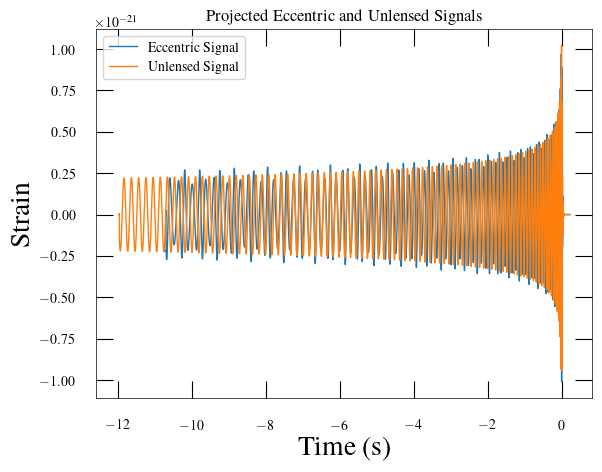

In [89]:
plt.plot(eccentric_signal.sample_times, eccentric_signal, label='Eccentric Signal')
plt.plot(unlensed_signal.sample_times, unlensed_signal, label='Unlensed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Projected Eccentric and Unlensed Signals')
plt.legend()
plt.show()

In [90]:
eccentric_signal = taper_timeseries(eccentric_signal, tapermethod="TAPER_STARTEND", return_lal=False)

eccentric_noisy, eccentric_snr = scale_signal(eccentric_signal)

####-----------------------Lensed Signal + Noise---------------------####

lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

lensed_noisy, lensed_snr = scale_signal(lensed_signal)

####-----------------------Unlensed Signal + Noise---------------------####

unlensed_signal = taper_timeseries(unlensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

unlensed_noisy, unlensed_snr = scale_signal(unlensed_signal)

####-------Cropping the signal such that it has duration of 8s-------####

# eccentric_noisy = eccentric_noisy.crop(left=24, right=0)
# lensed_noisy = lensed_noisy.crop(left=24, right=0)
# unlensed_noisy = unlensed_noisy.crop(left=24, right=0)

In [91]:
lensed_signal.duration, eccentric_signal.duration, unlensed_signal.duration, lensed_noisy.duration, eccentric_noisy.duration, unlensed_noisy.duration

(12.197021807338226, 10.9365234375, 12.197021484375, 32.0, 32.0, 32.0)

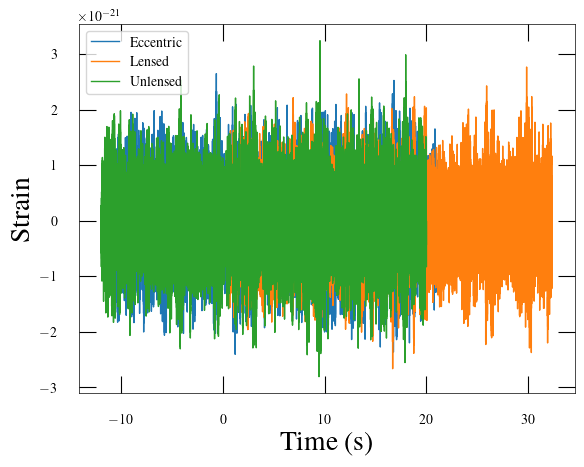

In [92]:
plt.plot(eccentric_noisy.sample_times, eccentric_noisy, label='Eccentric')
plt.plot(lensed_noisy.sample_times, lensed_noisy, label='Lensed')
plt.plot(unlensed_noisy.sample_times, unlensed_noisy, label='Unlensed')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()

In [93]:
lensed_noisy.start_time = eccentric_noisy.start_time
unlensed_noisy.start_time = eccentric_noisy.start_time

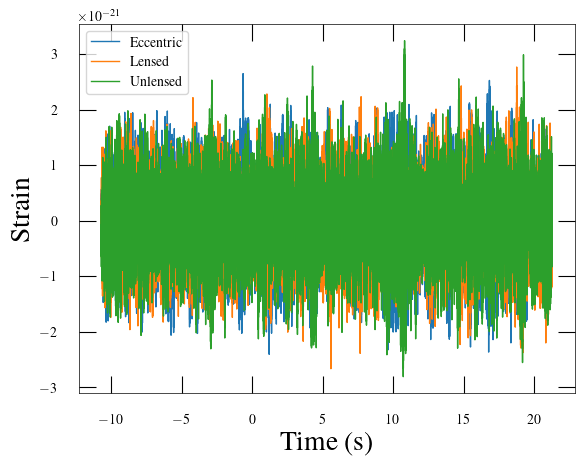

In [94]:
plt.plot(eccentric_noisy.sample_times, eccentric_noisy, label='Eccentric')
plt.plot(lensed_noisy.sample_times, lensed_noisy, label='Lensed')
plt.plot(unlensed_noisy.sample_times, unlensed_noisy, label='Unlensed')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()

In [95]:
# Resize the waveforms to the same length
tlen = max(len(hp), len(sp))
hp.resize(tlen)
sp.resize(tlen)

duration = max(hp.duration, sp.duration)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / duration
flen = tlen//2 + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 5.0)

# # Generate the aLIGO ZDHP PSD
# delta_f = 1.0 / eccentric_noisy.duration
# flen = tlen//2 + 1
# psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 5.0)

In [96]:
# match = pycbc.filter.match(eccentric_signal, unlensed_signal, psd = psd, low_frequency_cutoff=5, high_frequency_cutoff=None)[0]
match = pycbc.filter.match(hp, sp, psd = psd, low_frequency_cutoff=5, high_frequency_cutoff=None)[0]

ln_B_ecc_qc = 0.5 * (1 - match**2) * eccentric_snr**2
ln_B_qc_ecc = 0.5 * (1 - match**2) * unlensed_snr**2

print(f"Eccentric vs Unlensed Bayes Factor: {ln_B_ecc_qc}")
print(f"Unlensed vs Lensed Bayes Factor: {ln_B_qc_ecc}")

Eccentric vs Unlensed Bayes Factor: 39.02425771073233
Unlensed vs Lensed Bayes Factor: 41.427462833036884


In [97]:
match, eccentric_snr, unlensed_snr

(np.float64(0.9799580692634756),
 np.float64(44.349073190698924),
 np.float64(45.69423291081117))

## **SNR does not change (significantly) after cropping the signal.**

In [98]:
# noisy = eccentric_noisy.crop(left=2, right=0)

# template = eccentric_signal

# template.resize(len(noisy))

# tlen = len(template)

# delta_f = 1.0 / noisy.duration
# flen = tlen//2 + 1
# dummy_psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 5.0)

# snr = pycbc.filter.matched_filter(template = template,  data = noisy, psd = dummy_psd, low_frequency_cutoff=5)

# peak_snr = abs(snr).numpy().max()

# peak_snr

In [100]:
ln_B_required = np.random.uniform(1, 50)

required_snr = np.sqrt(2 * ln_B_required / (1 - match**2))
ln_B_required, required_snr

(10.617475371325154, np.float64(23.132781405982332))

In [101]:
distance = parameters['distance'] * eccentric_snr / required_snr
# distance = parameters['distance'] * np.sqrt(ln_B_ecc_qc / 24) * 10

In [102]:
parameters['distance'], distance

(np.float64(264.59779361161463), np.float64(507.2743613936654))

In [103]:
mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(parameters['chirp_mass'], parameters['mass_ratio'])

hp, hc = get_td_waveform(
    approximant='teobresums',
    mass1=mass1,
    mass2=mass2,
    lambda1=0,
    lambda2=0,
    spin1z=parameters['spin1z'],
    spin2z=parameters['spin2z'],
    distance=distance,
    delta_t=1.0 / 4096 ,
    ecc=parameters['eccentricity'],
    coa_phase=parameters['coa_phase'],
    f_lower=5,
)

sp, sc = get_td_waveform(
    approximant='teobresums',
    mass1=mass1,
    mass2=mass2,
    lambda1=0,
    lambda2=0,
    spin1z=parameters['spin1z'],
    spin2z=parameters['spin2z'],
    distance=distance,
    delta_t=1.0 / 4096 ,
    ecc=0,
    coa_phase=parameters['coa_phase'],
    f_lower=5,
)

####---------------------Projecting on detector--------------------####

detector = Detector('H1')

eccentric_signal = detector.project_wave(hp, hc, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

unlensed_signal = detector.project_wave(sp, sc, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

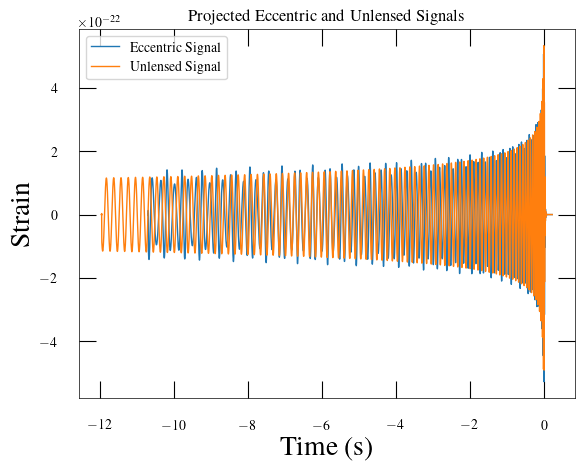

In [104]:
plt.plot(eccentric_signal.sample_times, eccentric_signal, label='Eccentric Signal')
plt.plot(unlensed_signal.sample_times, unlensed_signal, label='Unlensed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Projected Eccentric and Unlensed Signals')
plt.legend()
plt.show()

In [105]:
eccentric_signal = taper_timeseries(eccentric_signal, tapermethod="TAPER_STARTEND", return_lal=False)

eccentric_noisy, eccentric_snr = scale_signal(eccentric_signal)

####-----------------------Lensed Signal + Noise---------------------####

lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

lensed_noisy, lensed_snr = scale_signal(lensed_signal)

####-----------------------Unlensed Signal + Noise---------------------####

unlensed_signal = taper_timeseries(unlensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

unlensed_noisy, unlensed_snr = scale_signal(unlensed_signal)

####-------Cropping the signal such that it has duration of 8s-------####

# eccentric_noisy = eccentric_noisy.crop(left=24, right=0)
# lensed_noisy = lensed_noisy.crop(left=24, right=0)
# unlensed_noisy = unlensed_noisy.crop(left=24, right=0)

In [106]:
lensed_noisy.start_time = eccentric_noisy.start_time
unlensed_noisy.start_time = eccentric_noisy.start_time

In [107]:
# Resize the waveforms to the same length
tlen = max(len(hp), len(sp))
hp.resize(tlen)
sp.resize(tlen)

duration = max(hp.duration, sp.duration)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / duration
flen = tlen//2 + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 5.0)

# # Generate the aLIGO ZDHP PSD
# delta_f = 1.0 / eccentric_noisy.duration
# flen = tlen//2 + 1
# psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 5.0)

In [108]:
# import gwmat.methods.FF_computation as FF_computation

In [109]:
# #  ## WF Gen init arguments
# f_low, f_high = 5., None
# f_ref = f_low
# apx_inj = "teobresums"

# # ## FF comp init parms 
# apx_rec = "IMRPhenomPv2"
# wf_model = 'UL_4D'

# ## Generate signal
# Mtot, q = 120, 1
# Mlz, y = 1000, 1.0
# inj_prms = Mtot, q, Mlz, y

# # inj_res = gwmat.methods.FF_computation.inject_microlensed_signal(Mlz, y, Mtot, q, apx=apx_inj)

# # ## computing FF

# # lwf_fd = inj_res['lwf_fd']
# n_iters = 5
# kwargs = dict(Mtot=Mtot, q=q, Mlz=Mlz, y_lens=y, lambda1 = 0, lambda2=0,
#              max_wait_per_iter = 1e3, default_value = 0.0 )

# FF_res = FF_computation.compute_fitting_factor(eccentric_noisy, wf_model, apx=apx_rec, f_low=f_low, f_high=f_high, psd=psd, \
#                                   n_iters=[n_iters], xatols=['default'], max_iters=['default'], branch_num=None, branch_depth=None,\
#                                                   method='serial', **kwargs)

In [110]:
match = pycbc.filter.match(hp, sp, psd = psd, low_frequency_cutoff=5, high_frequency_cutoff=None)[0]
# match = pycbc.filter.match(eccentric_noisy, unlensed_noisy, psd = psd, low_frequency_cutoff=5, high_frequency_cutoff=None)[0]

ln_B_ecc_qc = 0.5 * (1 - match**2) * eccentric_snr**2
ln_B_qc_ecc = 0.5 * (1 - match**2) * unlensed_snr**2

print(f"Eccentric vs Unlensed Bayes Factor: {ln_B_ecc_qc}")
print(f"Unlensed vs Lensed Bayes Factor: {ln_B_qc_ecc}")

Eccentric vs Unlensed Bayes Factor: 10.150329514527616
Unlensed vs Lensed Bayes Factor: 11.110159079844111


In [111]:
match, eccentric_snr,  required_snr, ln_B_required

(np.float64(0.979958069263476),
 np.float64(22.618161120278995),
 np.float64(23.132781405982332),
 10.617475371325154)